In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import scanpy as sc

In [1]:
human = pd.read_csv('/home/zhaoyp/collaboration/haorui/humanCd8.csv', sep=' ')
human = human[human['p'] < 0.05]
human = human[human['OR'] != 0]
human = human[~human['OR'].isin([float('inf'), float('-inf')])]
human = human[human['OR'] < 1]

mouse = pd.read_csv("/home/zhaoyp/collaboration/haorui/result_0.1_1197_genes_Cd8.csv", sep=' ')
mouse = mouse[mouse['p'] < 0.05]
mouse = mouse[mouse['OR'] != 0]
mouse = mouse[~mouse['OR'].isin([float('inf'), float('-inf')])]
mouse = mouse[mouse['OR'] < 1]

mouse_human = pd.read_csv('/home/zhaoyp/collaboration/haorui/0.NatMed_Tatlas_lh/Complete List of Human and Mouse Homologs_FromMGI_version_09 May 2023.csv')
mouse_human = mouse_human[['DB Class Key', 'Common Organism Name', 'Symbol']]

In [2]:
mouse_human_t = mouse_human.pivot_table(index='Common Organism Name', 
                                      columns='DB Class Key', 
                                      values='Symbol', 
                                      aggfunc=lambda x: ' '.join(x)).T
mouse_human_t

Common Organism Name   human mouse, laboratory
DB Class Key                                  
43907370               WDR53             Wdr53
43907371                 TDG               Tdg
43907372              TRARG1            Trarg1
43907373               PDGFB             Pdgfb
43907374              GPR171            Gpr171
...                      ...               ...
43929194                 NaN           Zfp955a
43929195                 NaN            Zfp956
43929196                 NaN            Zfp964
43929197                 NaN              Zim1
43929198                 NaN     A430033K04Rik

[21828 rows x 2 columns]

In [3]:
import warnings
warnings.filterwarnings('ignore')

two_genes_com = []
for idx, row in mouse.iterrows():
    mouse_gene1 = row[0]
    mouse_gene2 = row[1]
    
    genes1 = mouse_human_t[mouse_human_t['mouse, laboratory'] == mouse_gene1].dropna(axis=1).values.flatten()
    genes2 = mouse_human_t[mouse_human_t['mouse, laboratory'] == mouse_gene2].dropna(axis=1).values.flatten()
    
    if len(genes1) == 0 or len(genes2) == 0:
        continue
        
    for g1 in genes1:
        for g2 in genes2:
            two_genes_com.append({
                'mouse.gene1': mouse_gene1,
                'mouse.gene2': mouse_gene2,
                'mouse.Or': row[2],
                'mouse.Pvalue': row[3],
                'TransGene1': g1,
                'TransGene2': g2
            })

two_genes_com = pd.DataFrame(two_genes_com)
two_genes_com['pair'] = two_genes_com['TransGene1'] + '_' + two_genes_com['TransGene2']

In [4]:
Matlas_count = pd.read_csv('Mslot.txt', sep='\t')
Hatlas_count = pd.read_csv('Hslot.txt', sep='\t')

In [5]:
import scanpy as sc

Matlas = sc.AnnData(Matlas_count.T)
Hatlas = sc.AnnData(Hatlas_count.T)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import scanpy as sc

# Matlas.write_h5ad('Matlas.h5ad')
# Hatlas.write_h5ad('Hatlas.h5ad')
Matlas = sc.read_h5ad('Matlas.h5ad')
Hatlas = sc.read_h5ad('Hatlas.h5ad')

In [73]:
mc = np.corrcoef(Matlas.X.T)
hc = np.corrcoef(Hatlas.X.T)

from sklearn.cluster import AgglomerativeClustering
from consensusclustering import ConsensusClustering

cc = ConsensusClustering(AgglomerativeClustering(metric='euclidean', linkage='average'),
                         min_clusters=2,
                         max_clusters=8,
                         n_resamples=100,
                         resample_frac=0.5,
                         k_param='n_clusters')
cc.fit(mc, progress_bar=True)

Computing consensus matrices:   0%|          | 0/7 [00:00<?, ?it/s]

In [74]:
bc = ConsensusClustering(AgglomerativeClustering(metric='euclidean', linkage='average'),
                         min_clusters=2,
                         max_clusters=8,
                         n_resamples=100,
                         resample_frac=0.5,
                         k_param='n_clusters')
bc.fit(hc, progress_bar=True)

Computing consensus matrices:   0%|          | 0/7 [00:00<?, ?it/s]

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


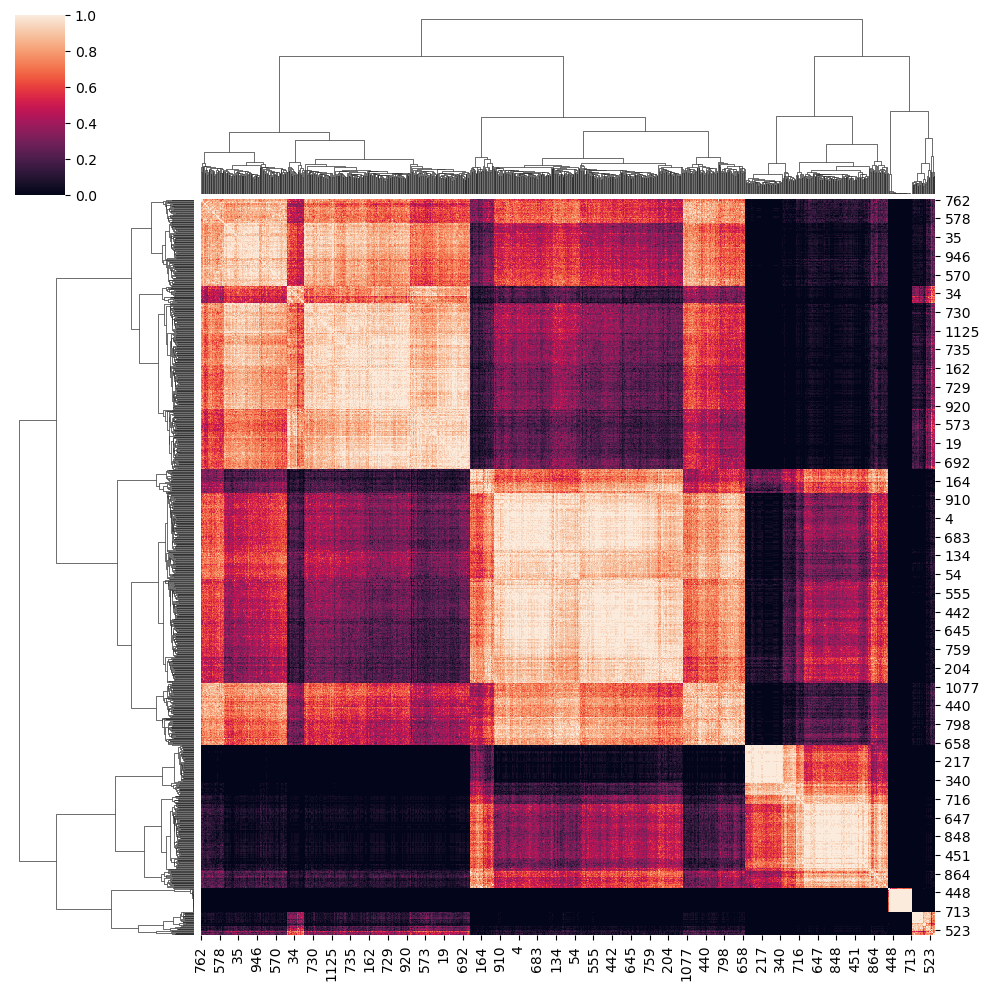

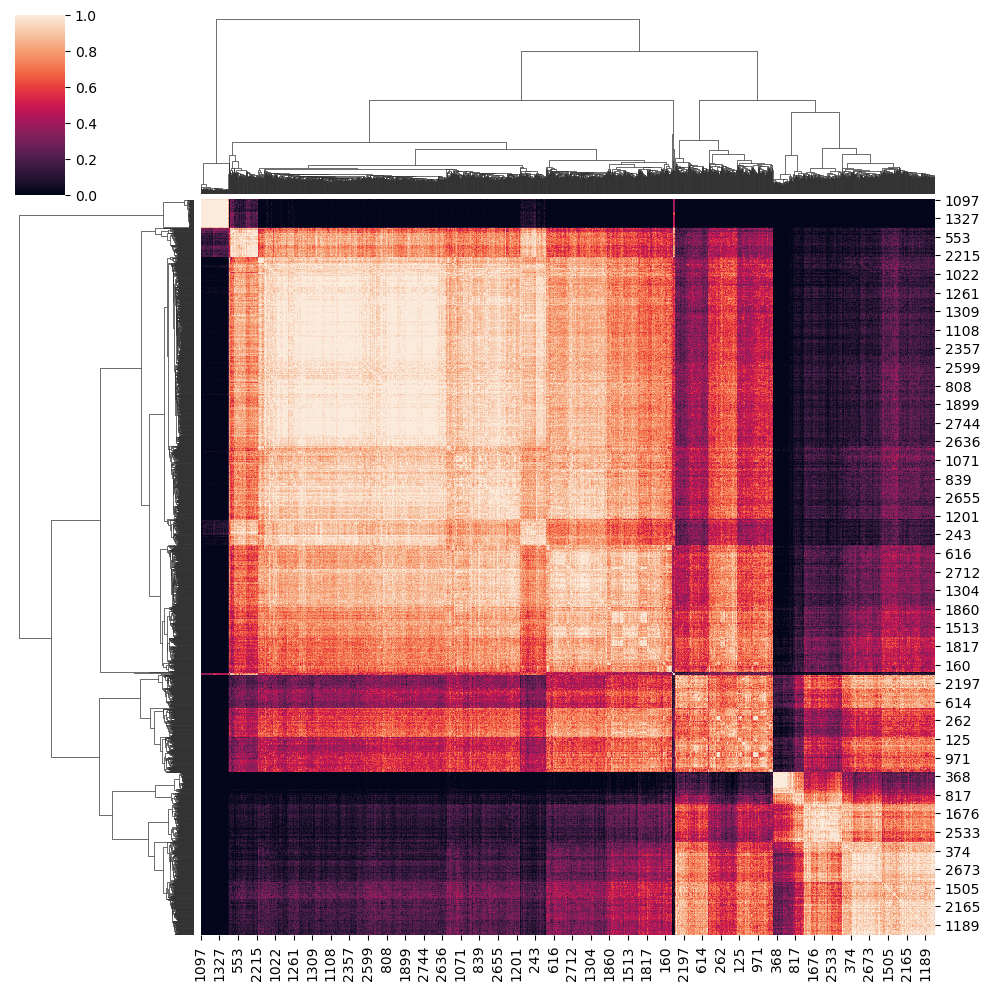

In [88]:
cc.plot_clustermap(cc.best_k())
bc.plot_clustermap(bc.best_k())

In [93]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from upsetplot import from_contents, UpSet

def get_module(mat, var_names, n_clusters):
    d = squareform(pdist(mat, metric='euclidean'))
    tree = linkage(d, method='ward')
    v = fcluster(tree, n_clusters, criterion='maxclust')
    gene_cluster = pd.DataFrame({'v': v})
    gene_cluster['gene'] = [name.split('.')[0] for name in var_names]
    return gene_cluster

Mmodule = get_module(mc, Matlas.var_names, cc.best_k())
Mmodule.columns = ['module_m', 'gene_m']
Mmodule['module_m'] = 'M-' + Mmodule['module_m'].astype(str)

Hmodule = get_module(hc, Hatlas.var_names, bc.best_k())
Hmodule.columns = ['module_h', 'gene_h']
Hmodule['module_h'] = 'H-' + Hmodule['module_h'].astype(str)

module_df = Mmodule.copy()
module_df['upper_gene'] = module_df['gene_m'].str.upper()

module_df = pd.concat([module_df.set_index('upper_gene'), Hmodule.set_index('gene_h')], axis=1)
module_df = module_df.dropna(subset=['module_h', 'module_m'])

# module_df.loc[module_df['module_h'] == 'H-2', 'module_h'] = 'tmp'
# module_df.loc[module_df['module_h'] == 'H-1', 'module_h'] = 'H-2'
# module_df.loc[module_df['module_h'] == 'tmp', 'module_h'] = 'H-1'

module_df.loc[module_df['module_m'] == 'M-5', 'module_m'] = 'M-3'

module_df['upper_gene'] = module_df.index

/tmp/ipykernel_66657/3509777536.py:10: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tree = linkage(d, method='ward')
/tmp/ipykernel_66657/3509777536.py:10: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tree = linkage(d, method='ward')


/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewid

<Figure size 700x400 with 0 Axes>

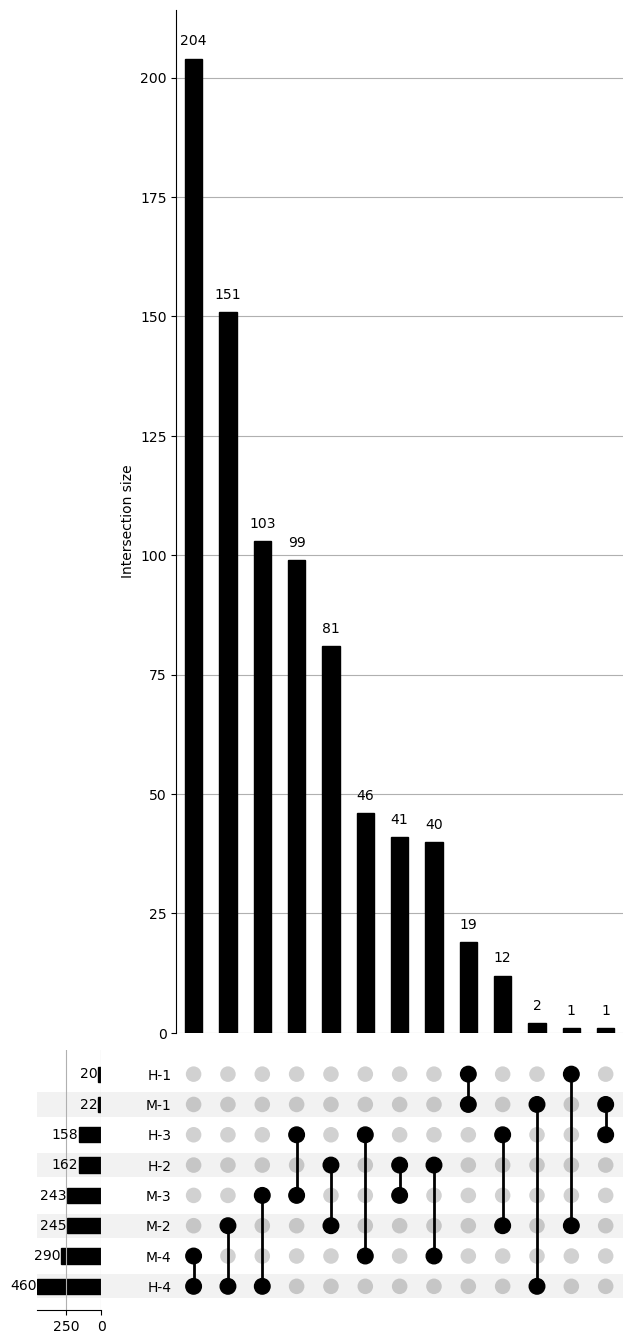

In [115]:
Input = {}
for item in pd.unique(module_df[['module_m', 'module_h']].values.ravel('K')):
    m = module_df.loc[module_df['module_m'] == item, 'upper_gene'].tolist()
    h = module_df.loc[module_df['module_h'] == item, 'upper_gene'].tolist()
    if m:
        Input[item] = m
    if h:
        Input[item] = h

Input = {k: v for k, v in Input.items() if v}

plt.figure(figsize=(7, 4))
upset = UpSet(from_contents(Input), sort_by='cardinality', show_counts='%d', intersection_plot_elements=30)
upset.plot()
plt.show()

In [123]:
module_df

module_m   gene_m module_h upper_gene
ABLIM1       M-3   Ablim1      H-4     ABLIM1
ABRACL       M-4   Abracl      H-4     ABRACL
ACAA2        M-2    Acaa2      H-2      ACAA2
ACAP1        M-4    Acap1      H-4      ACAP1
ACO2         M-4     Aco2      H-4       ACO2
...          ...      ...      ...        ...
SNRPF        M-3    Snrpf      H-4      SNRPF
NDUFA6       M-4   Ndufa6      H-4     NDUFA6
COX8A        M-3    Cox8a      H-4      COX8A
SCAND1       M-3   Scand1      H-4     SCAND1
DNAJC15      M-4  Dnajc15      H-2    DNAJC15

[800 rows x 4 columns]

In [128]:
shared_indices_h = {}
shared_indices_m = {}
for i in range(1, 5):
    shared = module_df[(module_df['module_h'] == f'H-{i}') & (module_df['module_m'] == f'M-{i}')]
    shared_indices_m[f'M-{i}_H-{i}'] = Mmodule[Mmodule['gene_m'].isin(shared['gene_m'])].index.tolist()
    shared_indices_h[f'M-{i}_H-{i}'] = Hmodule[Hmodule['gene_h'].isin(shared['upper_gene'])].index.tolist()

In [139]:
mc[shared_indices_m['M-1_H-1'] + shared_indices_m['M-2_H-2'] + shared_indices_m['M-3_H-3'] + shared_indices_m['M-4_H-4'],:][:,shared_indices_m['M-1_H-1'] + shared_indices_m['M-2_H-2'] + shared_indices_m['M-3_H-3'] + shared_indices_m['M-4_H-4']].shape

(403, 403)

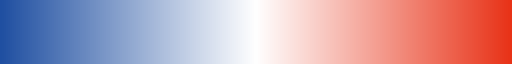

In [153]:
from types import new_class
from matplotlib.colors import LinearSegmentedColormap

colors = ['#1f4fa1', '#ffffff', '#e83217']
n_bins = 256

new_cmap = LinearSegmentedColormap.from_list('custom_diverging', colors, N=n_bins)
new_cmap

In [171]:
sns.heatmap?

Signature:
sns.heatmap(
    data,
    *,
    vmin=None,
    vmax=None,
    cmap=None,
    center=None,
    robust=False,
    annot=None,
    fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=False,
    xticklabels='auto',
    yticklabels='auto',
    mask=None,
    ax=None,
    **kwargs,
)
Docstring:
Plot rectangular data as a color-encoded matrix.

This is an Axes-level function and will draw the heatmap into the
currently-active Axes if none is provided to the ``ax`` argument.  Part of
this Axes space will be taken and used to plot a colormap, unless ``cbar``
is False or a separate Axes is provided to ``cbar_ax``.

Parameters
----------
data : rectangular dataset
    2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
    is provided, the index/column information will be used to label the
    columns and rows.
vmin, vmax : floats, optional
    Values to anchor the colormap, otherwise

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


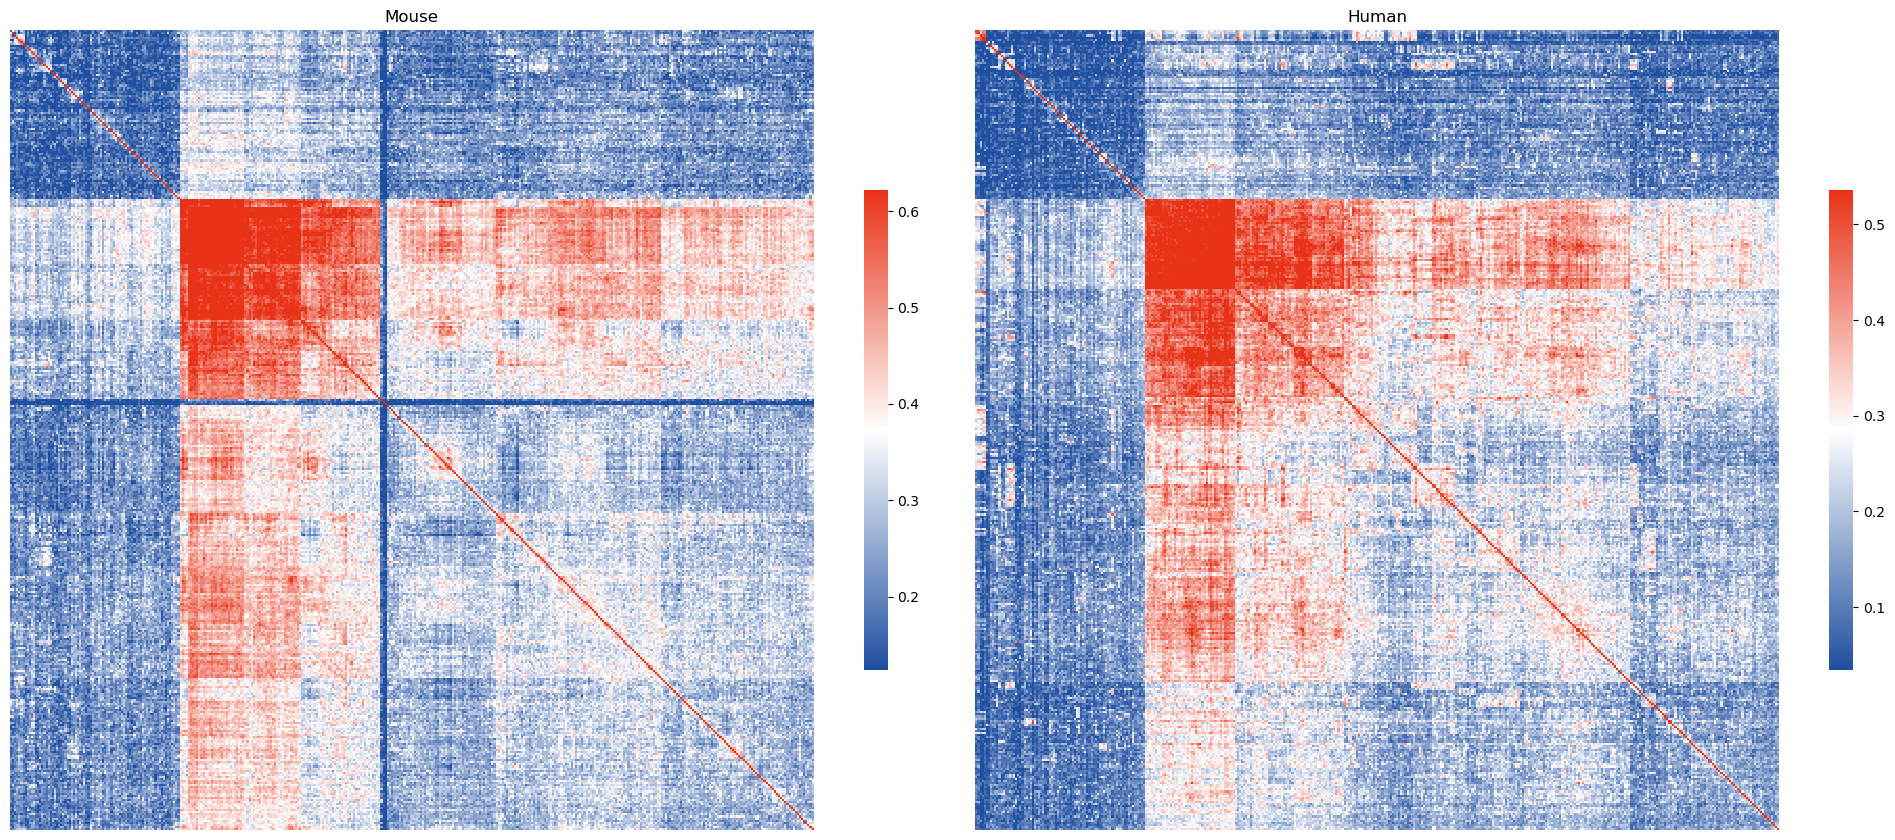

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare annotations
annotate_m = Mmodule.drop(columns=['gene_m'])
annotate_m['module_m'] = annotate_m['module_m'].astype('category')

annotate_h = Hmodule.drop(columns=['gene_h'])
annotate_h['module_h'] = annotate_h['module_h'].astype('category')

# Define annotation colors
# annotation_col_m = {'module_m': {'M-1': 'plum2', 'M-2': 'lightpink1', 'M-3': 'skyblue2'}}
# annotation_col_h = {'module_h': {'H-1': 'plum2', 'H-2': 'lightpink1', 'H-3': 'skyblue2'}}

# Plot heatmaps
plt.figure(figsize=(20, 8.5))

index_m = {}
for i in range(2, 5):
    cluster = sns.clustermap(mc[shared_indices_m[f'M-{i}_H-{i}'], :][:, shared_indices_m[f'M-{i}_H-{i}']])
    index_m[i] = np.array(shared_indices_m[f'M-{i}_H-{i}'])[cluster.dendrogram_col.reordered_ind]
    index_m[i] = index_m[i].tolist()
    plt.close()

index_h = {}
for i in range(2, 5):
    cluster = sns.clustermap(hc[shared_indices_h[f'M-{i}_H-{i}'], :][:, shared_indices_h[f'M-{i}_H-{i}']])
    index_h[i] = np.array(shared_indices_h[f'M-{i}_H-{i}'])[cluster.dendrogram_col.reordered_ind]
    index_h[i] = index_h[i].tolist()
    plt.close()

# Mouse heatmap
plt.subplot(1, 2, 1)
sns.heatmap(mc[index_m[2] + index_m[3] + index_m[4],:] \
               [:,index_m[2] + index_m[3] + index_m[4]], 
                cmap=new_cmap, cbar=True, cbar_kws={'shrink': 0.6}, xticklabels=False, yticklabels=False, robust=True,)
plt.title("Mouse")

# Human heatmap
plt.subplot(1, 2, 2)
sns.heatmap(hc[index_h[2] + index_h[3] + index_h[4],:] \
               [:,index_h[2] + index_h[3] + index_h[4]], 
                cmap=new_cmap, cbar=True, cbar_kws={'shrink': 0.6}, xticklabels=False, yticklabels=False, robust=True)
plt.title("Human")

plt.tight_layout()

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./plots/exclusive_clustermap.pdf', bbox_inches='tight', format='pdf')
plt.show()


In [151]:
df = pd.DataFrame()
for i in range(1, 5):
    df = pd.concat([df, module_df[(module_df['module_m'] == f'M-{i}') & (module_df['module_h'] == f'H-{i}')]])
df.to_csv('module_df.csv', index=False)

In [189]:
df.gene_m

ADGRE5        Adgre5
ARHGAP45    Arhgap45
COPS9          Cops9
ELOB            Elob
HNRNPDL      Hnrnpdl
              ...   
WASF2          Wasf2
WBP2            Wbp2
WNK1            Wnk1
YWHAQ          Ywhaq
NDUFA6        Ndufa6
Name: gene_m, Length: 403, dtype: object

In [190]:
hk_df = pd.read_csv('/home/wpy/stereoseq/20240702-Exclusive/He2020Nature_mouseHK.txt', sep='\t').T
np.intersect1d(hk_df.index.tolist(), df.gene_m.tolist())

array([], dtype='<U14')

In [201]:
m_umap = pd.read_csv('Matlas_umap.csv', index_col=0)
Matlas.obsm['X_umap'] = m_umap.values

In [204]:
h_umap = pd.read_csv('Hatlas_umap.csv', index_col=0)
Hatlas.obsm['X_umap'] = h_umap.values

In [208]:
m_obs = pd.read_csv('Matlas_obs.csv', index_col=0)
h_obs = pd.read_csv('Hatlas_obs.csv', index_col=0)

Matlas.obs = m_obs
Hatlas.obs = h_obs

In [213]:
Matlas.write_h5ad('Matlas.h5ad')
Hatlas.write_h5ad('Hatlas.h5ad')

In [5]:
Matlas = sc.read_h5ad('Matlas.h5ad')
Hatlas = sc.read_h5ad('Hatlas.h5ad')

df = pd.read_csv('module_df.csv')

/tmp/ipykernel_2300/3386238635.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_2300/3386238635.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_2300/3386238635.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_2300/3386238635.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)


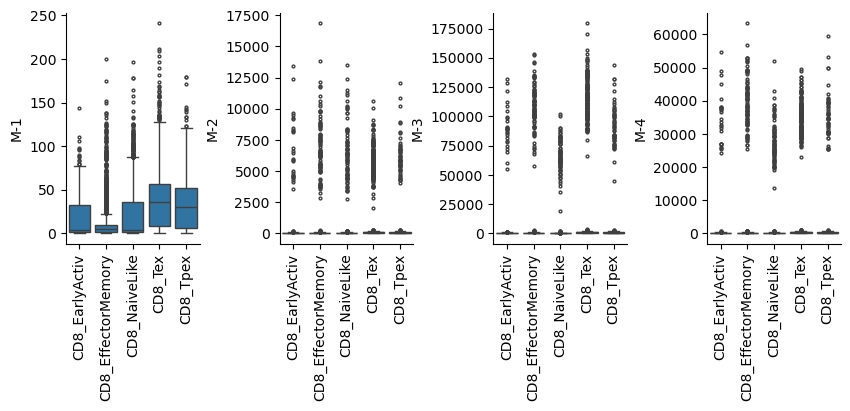

In [6]:
Matlas.obs['M-1'] = Matlas[:, df.loc[df.module_h == 'H-1', 'gene_m'].tolist()].X.toarray().sum(axis=1).flatten()
Matlas.obs['M-2'] = Matlas[:, df.loc[df.module_h == 'H-2', 'gene_m'].tolist()].X.toarray().sum(axis=1).flatten()
Matlas.obs['M-3'] = Matlas[:, df.loc[df.module_h == 'H-3', 'gene_m'].tolist()].X.toarray().sum(axis=1).flatten()
Matlas.obs['M-4'] = Matlas[:, df.loc[df.module_h == 'H-4', 'gene_m'].tolist()].X.toarray().sum(axis=1).flatten()

sub_Matlas = Matlas[Matlas.obs['functional.cluster'].str.contains('CD8')]
plot_df = sub_Matlas.obs[['M-1', 'M-2', 'M-3', 'M-4', 'functional.cluster']]
plot_df = plot_df.set_index('functional.cluster').melt(ignore_index=False).reset_index()

_, axs = plt.subplots(1, 4, figsize=(10, 3))
for i in range(4):
    sns.boxplot(plot_df[(plot_df.variable == f'M-{i+1}') & (plot_df['functional.cluster'].str.contains('CD8'))], x='functional.cluster', y='value', ax=axs[i], legend=False, fliersize=2)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
    axs[i].set_ylabel(f'M-{i+1}')
    axs[i].set_xlabel('')
    sns.despine(ax=axs[i])
    # plt.legend(frameon=False, bbox_to_anchor=(1, 1))
plt.subplots_adjust(wspace=0.6)

/tmp/ipykernel_2300/2277751581.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_2300/2277751581.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_2300/2277751581.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_2300/2277751581.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)


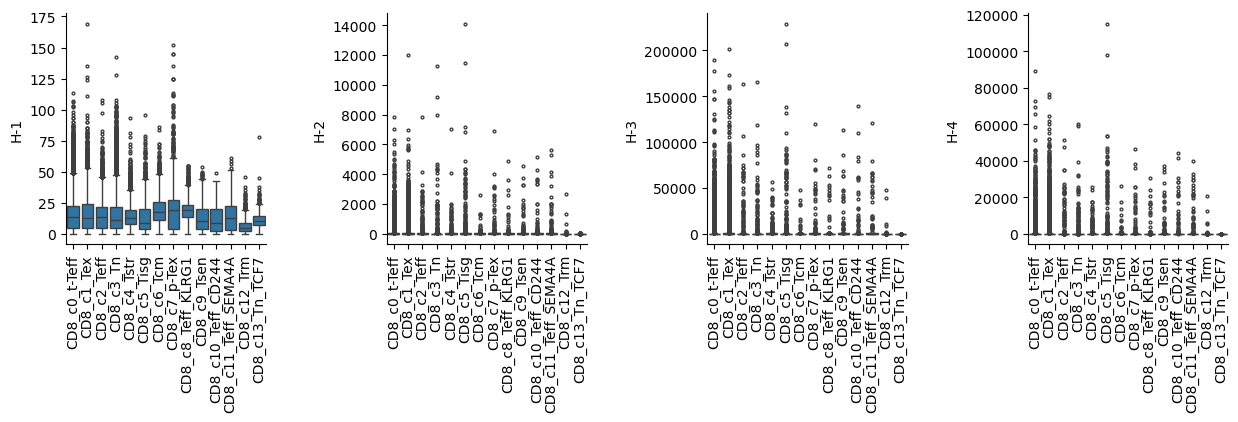

In [9]:
Hatlas.obs['M-1'] = Hatlas[:, df.loc[df.module_h == 'H-1', 'upper_gene'].tolist()].X.toarray().sum(axis=1).flatten()
Hatlas.obs['M-2'] = Hatlas[:, df.loc[df.module_h == 'H-2', 'upper_gene'].tolist()].X.toarray().sum(axis=1).flatten()
Hatlas.obs['M-3'] = Hatlas[:, df.loc[df.module_h == 'H-3', 'upper_gene'].tolist()].X.toarray().sum(axis=1).flatten()
Hatlas.obs['M-4'] = Hatlas[:, df.loc[df.module_h == 'H-4', 'upper_gene'].tolist()].X.toarray().sum(axis=1).flatten()

sub_Hatlas = Hatlas[Hatlas.obs['cell.type'].str.contains('CD8')]
plot_df = sub_Hatlas.obs[['M-1', 'M-2', 'M-3', 'M-4', 'cell.type']]
plot_df = plot_df.set_index('cell.type').melt(ignore_index=False).reset_index()

_, axs = plt.subplots(1, 4, figsize=(15, 3))
for i in range(4):
    sns.boxplot(plot_df[(plot_df.variable == f'M-{i+1}') & (plot_df['cell.type'].str.contains('CD8'))], x='cell.type', y='value', ax=axs[i], legend=False, fliersize=2)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
    axs[i].set_ylabel(f'H-{i+1}')
    axs[i].set_xlabel('')
    sns.despine(ax=axs[i])
    # plt.legend(frameon=False, bbox_to_anchor=(1, 1))
plt.subplots_adjust(wspace=0.6)

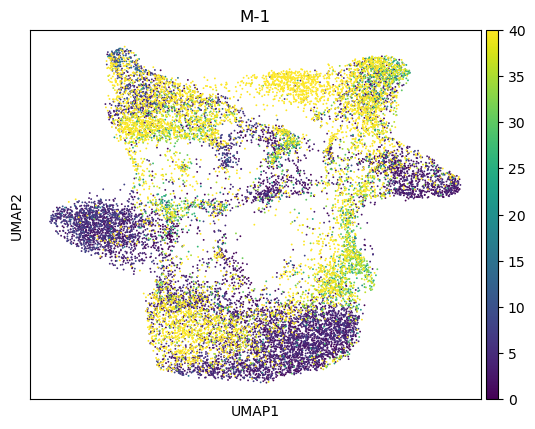

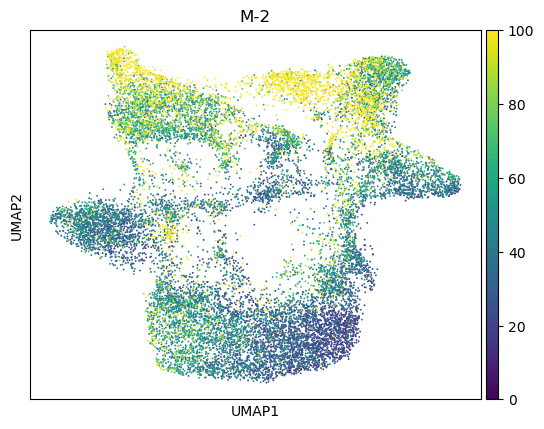

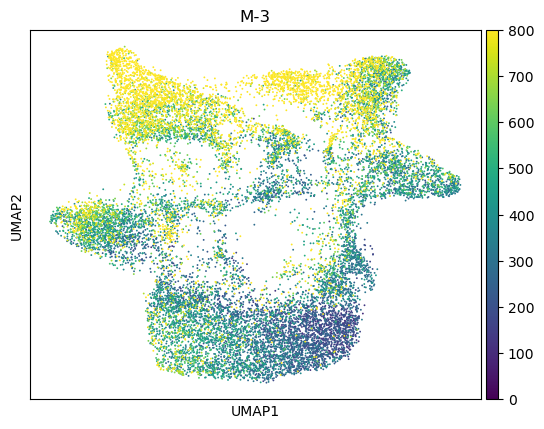

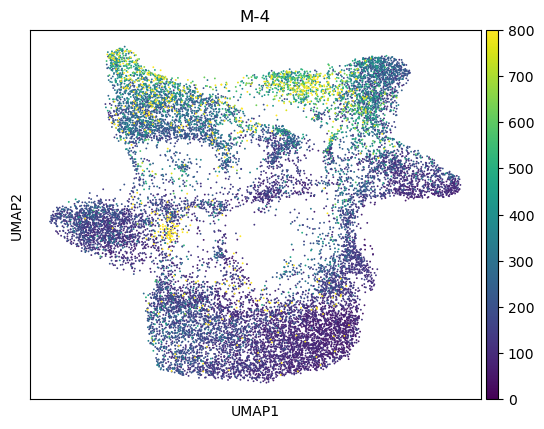

In [ ]:
sc.pl.umap(Matlas, color=['M-1'], vmax=40, vmin=0)
sc.pl.umap(Matlas, color=['M-2'], vmax=100, vmin=0)
sc.pl.umap(Matlas, color=['M-3'], vmax=800, vmin=0)
sc.pl.umap(Matlas, color=['M-4'], vmax=800, vmin=0)